In [1]:
%matplotlib inline

In [2]:
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from matplotlib import pyplot as plt
from tqdm.auto import tqdm as pbar

from ihrem.timeslice import ms
from ihrem.analysis import stim
from ihrem.analysis import cycles

from ihrem.analysis import prc, prc_plot

from ihrem.figs_cpg import fig5

In [3]:
phase_time = ms(seconds=-5)

In [4]:
reg_sel = fig5.load_reg()

analysis_windows = stim.collect_analysis_windows(reg_sel, pulse_len=(ms(seconds=1)), align_to='stop').sel(noisy=False)

reg_sel = reg_sel.sel_mask(analysis_windows['exp_name'].unique())

exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()
exp_beta_detailed['seeing'] = fig5.label_seeing(exp_beta_detailed)
exp_beta_detailed['cap_mode'] = fig5.label_cap_mode(exp_beta_detailed)

exp_beta_comb = exp_beta_detailed.groupby_max('exp_name')

beta_acorrs = exp_beta_detailed.crop((ms(hours=2), ms(hours=11))).auto_corr(pearson=True)
exp_beta_detailed['cycle_length'] = cycles.estimate_interval(beta_acorrs)

exp_phase_comb = prc.collect_beta_phases(exp_beta_comb)
phase_comb_cut = prc.get_phase_cut(exp_phase_comb, analysis_windows, name='comb', phase_time=phase_time)

exp_phase_detailed = prc.collect_beta_phases(exp_beta_detailed)
phase_detailed_cut = prc.get_phase_cut(exp_phase_detailed, analysis_windows, name='single', phase_time=phase_time)


# We re-normalize because some artifacts late/early may shrink beta
# But the analysis windows are big enough to get reasonable statistics for normalization
beta_detailed_cut = exp_beta_detailed.cut_merge(analysis_windows).normalize_by_quantiles()
beta_comb_cut = beta_detailed_cut.groupby_max('win_idx').set_index('win_idx')


# Copy over the phase
beta_detailed_cut = beta_detailed_cut.set_cols(phase_detailed_cut[['phase_single', 'phase_single_cat']])

beta_detailed_cut['phase_comb'] = phase_comb_cut.reg['phase_comb'].reindex(beta_detailed_cut['win_idx']).values
beta_detailed_cut['phase_comb_cat'] = phase_comb_cut.reg['phase_comb_cat'].reindex(beta_detailed_cut['win_idx']).values

phase_detailed_cut = phase_detailed_cut.set_cols(beta_detailed_cut[['phase_comb', 'phase_comb_cat']])

Taking 97/204 experiments


  0%|          | 0/97 [00:00<?, ?it/s]

Found 386 pulses in total


load beta:   0%|          | 0/27 [00:00<?, ?it/s]

# Fig5 af: single trials

In [5]:
def plot_all_beta_spread_per_exp(reg_sel, beta_detailed_cut, fill=False):

    for exp_name, traces in pbar(beta_detailed_cut.iter_grouped('exp_name'),
                                 total=beta_detailed_cut['exp_name'].nunique()):

        f = prc_plot.plot_beta_spread_single_exp(
            traces.clip(upper=2).downsample(1000).crop((ms(minutes=-10), ms(minutes=+15))),
            left_fill=fill,
            right_fill=fill,
            max_fill=not fill,
        )

        cap = reg_sel.loc[exp_name, 'cap']

        f.suptitle(
            f'{exp_name} (n={len(traces.index) / 2:g}) {cap}-cap',
            color=prc_plot.CAP_COLORS[cap],
            fontsize=6,
        )
        
        subfolder = 'beta_filled' if fill else 'beta_lines'

        fig5.savefig(
            f,
            f'{subfolder}/beta_{cap}_cap_{exp_name}'
        )


        
# This takes long !!

# plot_all_beta_spread_per_exp(
#     reg_sel,
#     beta_detailed_cut,
#     fill=False,
#
# )

# Fig5 bcd phase dependencty

Saving: /gpfs/laur/data/fenkl/from_luis/fig5/phase_dependency_unilat_cap.pdf
Saving: /gpfs/laur/data/fenkl/from_luis/fig5/phase_dependency_bilat_cap.pdf
Saving: /gpfs/laur/data/fenkl/from_luis/fig5/phase_dependency_no_cap.pdf


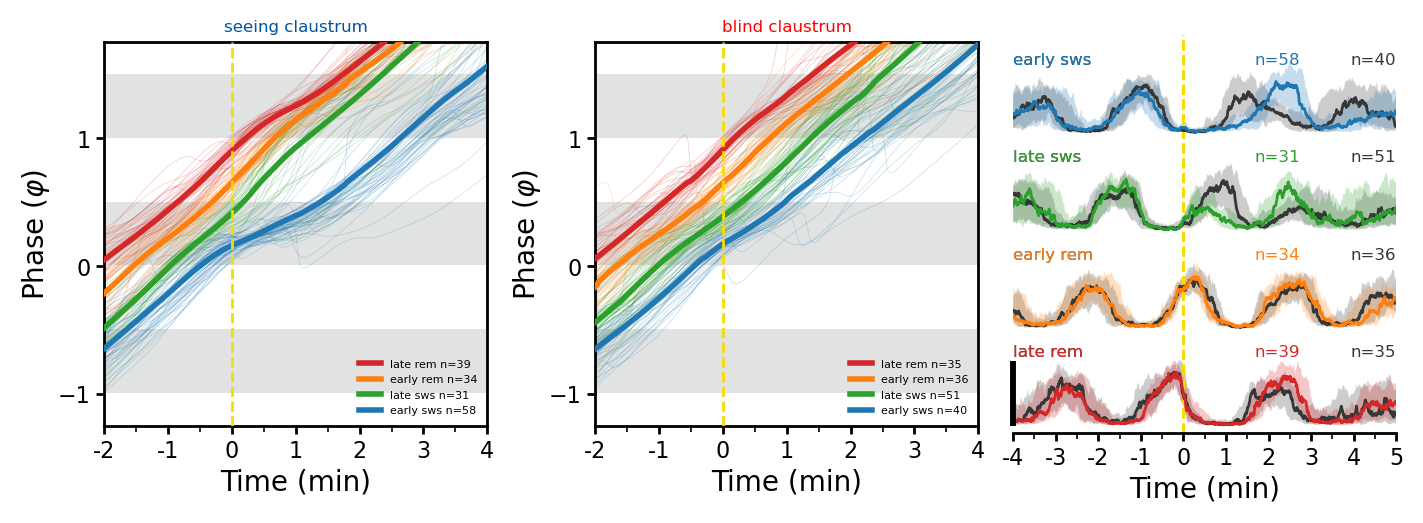

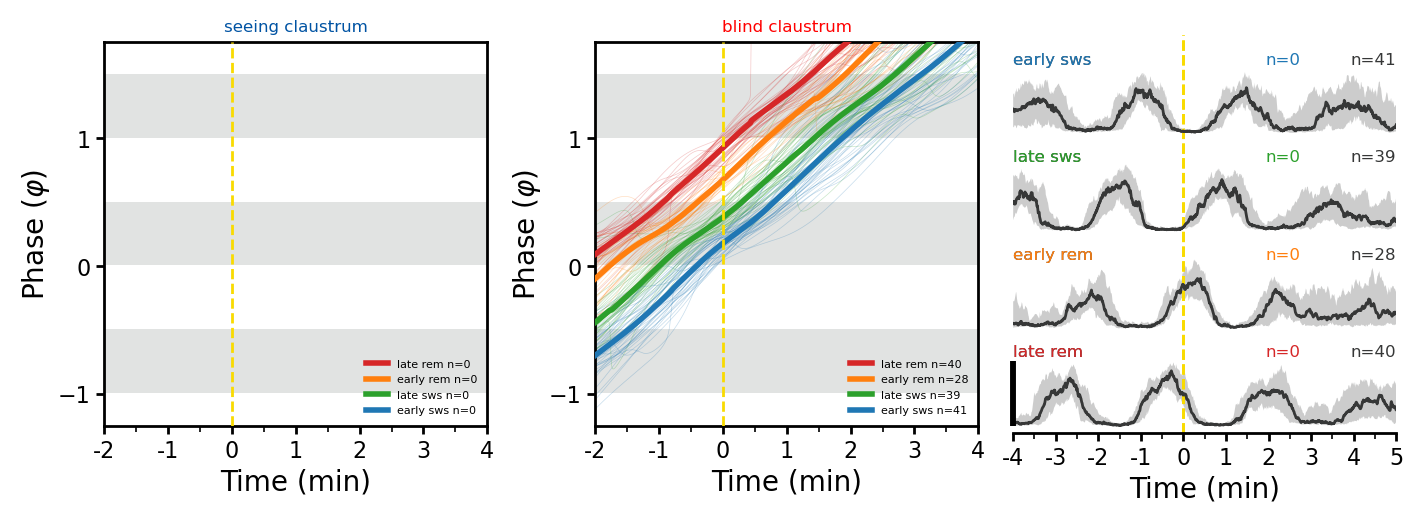

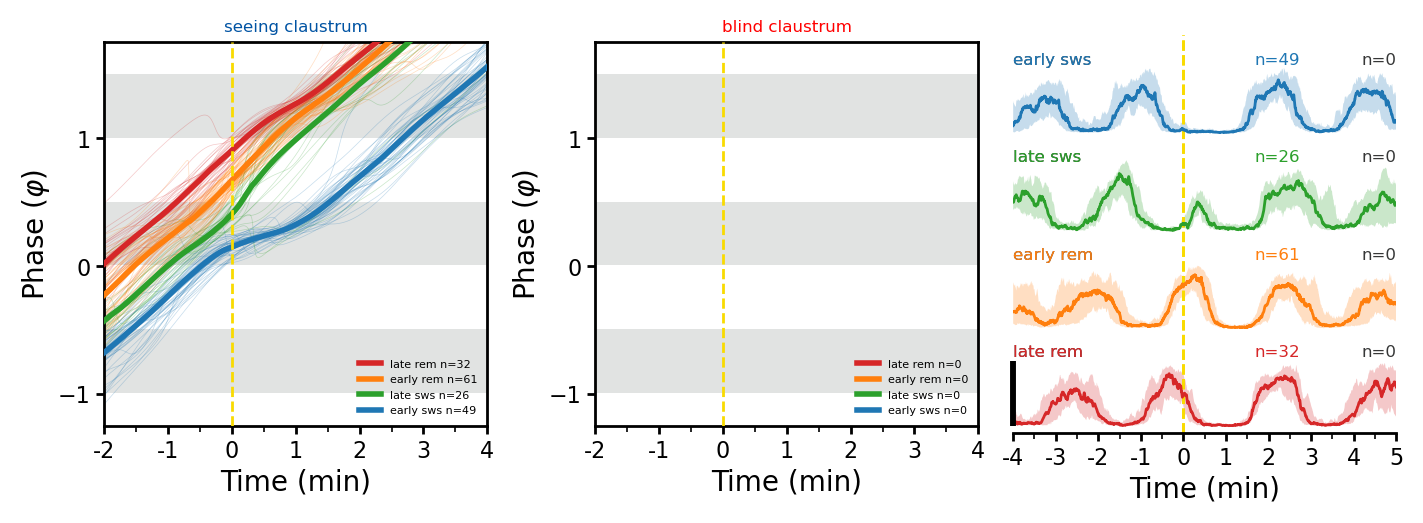

In [6]:
for cap_mode in ['unilat', 'bilat', 'no']:
    f = prc_plot.plot_phase_dependency(
        beta_detailed_cut.sel(cap_mode=cap_mode),
        phase_detailed_cut.sel(cap_mode=cap_mode),
    )
    fig5.savefig(f, f'phase_dependency_{cap_mode}_cap')


In [7]:
phase_detailed_cut['phase_diff'] = prc.take_phase_diff(phase_detailed_cut, phase_time, class_by='phase_single')

Saving: /gpfs/laur/data/fenkl/from_luis/fig5/prc_unilat_cap_seeing.pdf
Saving: /gpfs/laur/data/fenkl/from_luis/fig5/prc_unilat_cap_blind.pdf
Saving: /gpfs/laur/data/fenkl/from_luis/fig5/prc_bilat_cap_blind.pdf
Saving: /gpfs/laur/data/fenkl/from_luis/fig5/prc_no_cap_seeing.pdf


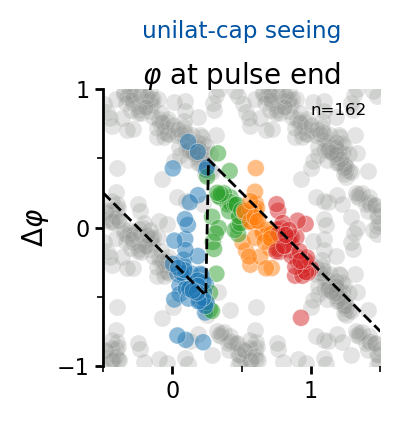

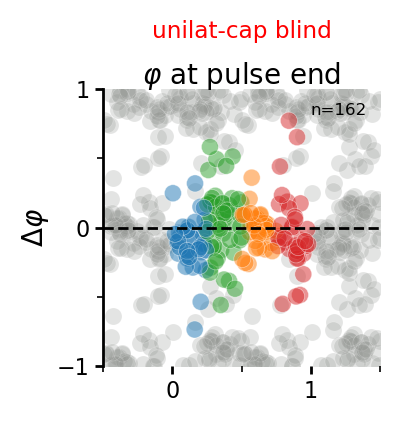

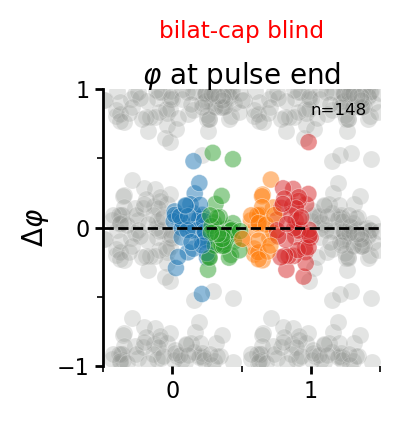

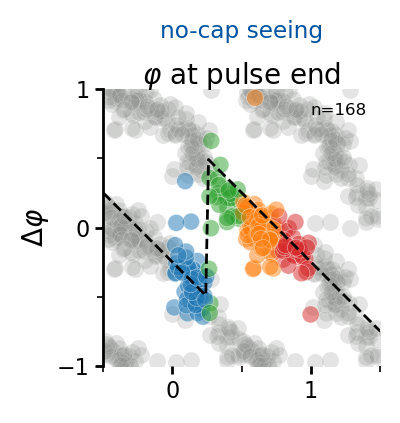

In [8]:
for (cap_mode, seeing) in [('unilat', 'seeing'), ('unilat', 'blind'), ('bilat', 'blind'), ('no', 'seeing')]:

    f, ax = plt.subplots(figsize=(2.5, 2))
    prc_plot.plot_prc_single(
        ax,
        phase_detailed_cut.sel(cap_mode=cap_mode, seeing=seeing),
        class_by='phase_single',
        line='diag' if seeing == 'seeing' else 'flat',
    )
    f.suptitle(f'{cap_mode}-cap {seeing}', color=prc_plot.CAP_COLORS[seeing])
    fig5.savefig(f, f'prc_{cap_mode}_cap_{seeing}')


# Fig 5e: barcode

In [9]:
%%time

exp_rem_wins = cycles.extract_rem_wins_multi(exp_beta_comb)
rem_traces = cycles.extract_rem_traces(analysis_windows, exp_rem_wins)

rem wins:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

CPU times: user 4min 17s, sys: 19min 59s, total: 24min 16s
Wall time: 29.2 s


In [10]:
%%time

highest_beta_traces = beta_detailed_cut.groupby_mix('win_idx', pd.DataFrame.idxmax)
highest_beta_traces = highest_beta_traces.applymap(lambda x: beta_detailed_cut.loc[x, 'side'])
highest_beta_traces = highest_beta_traces.set_index('win_idx')

CPU times: user 42.4 s, sys: 78.4 ms, total: 42.4 s
Wall time: 42.4 s


In [11]:
%%time

strong_traces = fig5.combine_dom_and_rem_traces(highest_beta_traces, rem_traces)

CPU times: user 3.73 s, sys: 108 ms, total: 3.84 s
Wall time: 3.8 s


In [12]:
%%time

strong_traces_sorted = fig5.sort_lead_unilat(strong_traces)

  0%|          | 0/162 [00:00<?, ?it/s]

CPU times: user 680 ms, sys: 24.9 ms, total: 705 ms
Wall time: 699 ms


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig5/barcode.pdf
CPU times: user 15.3 s, sys: 837 ms, total: 16.1 s
Wall time: 15.3 s


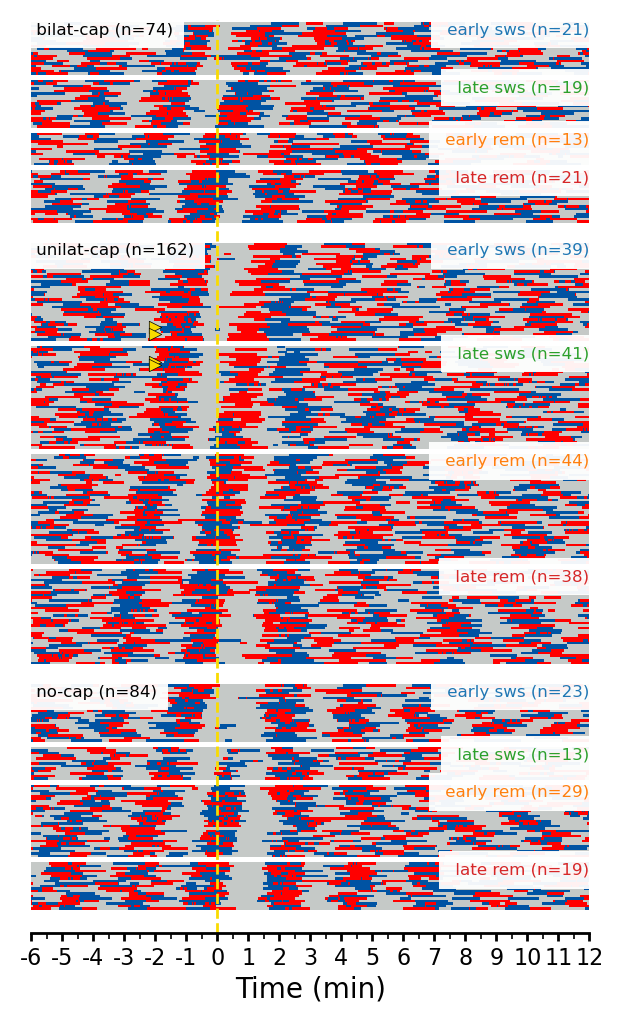

In [13]:
%%time

f = fig5.plot_lead_traces_barcode(
    strong_traces_sorted.sel(noisy=False).sort_values(['cap_mode', 'phase_comb']).crop((ms(minutes=-6), ms(minutes=+12))),
    highlight=strong_traces_sorted.sel(decoupled=True).index,
)
fig5.savefig(f, 'barcode')

# Fig 5fg: Re-sync

In [14]:
strong_traces_sorted[f'time_to_first_sws'] = fig5.extract_time_to_first_sws(strong_traces_sorted)

  0%|          | 0/320 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig5/time_to_resync.pdf


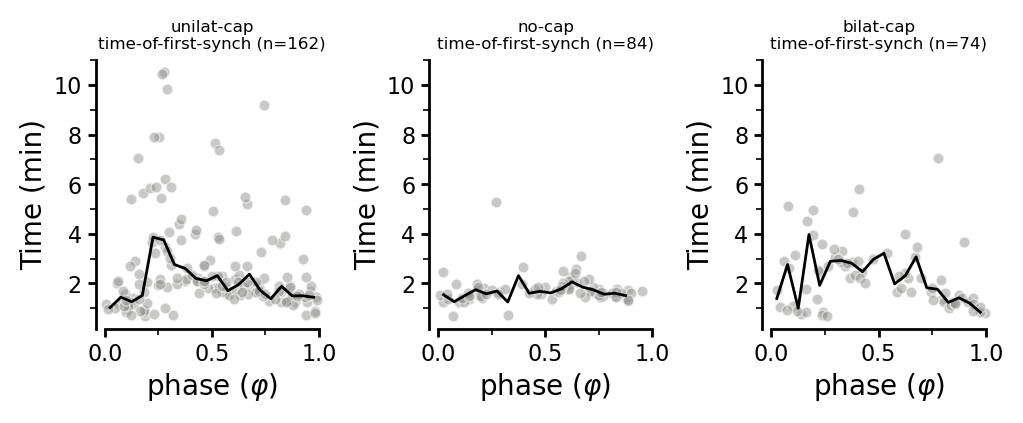

In [15]:
f = fig5.plot_time_to_sws_vs_phase_multi(strong_traces_sorted)

fig5.savefig(f, 'time_to_resync')

## Revisions: Animal and Time-of-night doesn't affect

Saving: /gpfs/laur/data/fenkl/from_luis/fig5/time_to_resync_detailed.pdf


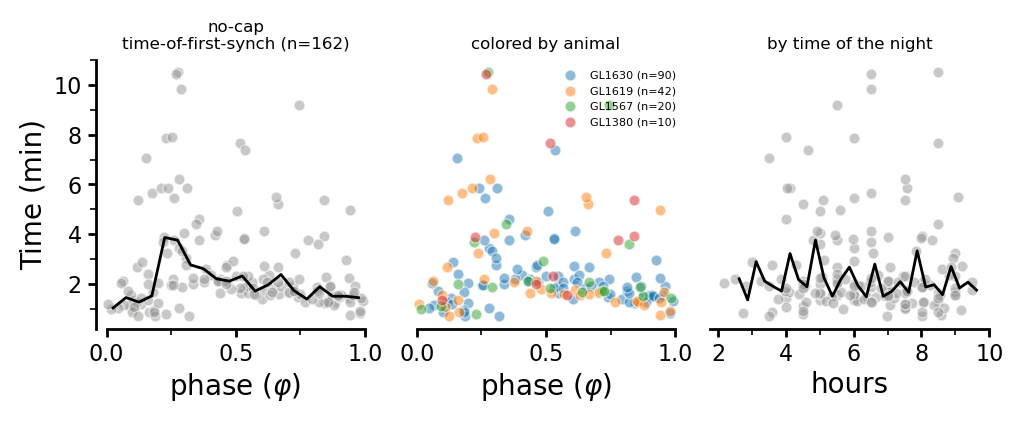

In [16]:
# Now per animal
f = fig5.plot_time_to_sws_vs_other(strong_traces_sorted, cap_mode)

fig5.savefig(f, 'time_to_resync_detailed')